In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import MinMaxScaler


Bad key savefig.frameon in file c:\Users\scott\anaconda3\envs\pyvizenv\envs\pyvizenv2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file c:\Users\scott\anaconda3\envs\pyvizenv\envs\pyvizenv2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file c:\Users\scott\anaconda3\envs\pyvizenv\envs\pyvizenv2\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log fi

In [2]:

file_medical = Path("Medical00_22.csv")
file_cpi = Path("CPI_Average.csv")

In [3]:


medical_file = pd.read_csv(file_medical)
CPI_file = pd.read_csv(file_cpi)

In [4]:


df_medical = pd.DataFrame(medical_file)
df_medical.set_index(pd.to_datetime(df_medical['Year'], infer_datetime_format=True), inplace=True)
df_medical = df_medical.drop(columns=['Year'], axis=1)
df_medical = df_medical.pct_change()


df_cpi = pd.DataFrame(CPI_file)
df_cpi.set_index(pd.to_datetime(df_cpi['Year'], infer_datetime_format=True), inplace=True) 
df_cpi = df_cpi.drop(columns=['Year'], axis=1)
df_cpi  = df_cpi.pct_change()


In [5]:
df_inflation = pd.concat([df_medical, df_cpi], axis="columns", join = "inner")

In [6]:
def fill_missing(values):
    one_month = 30
    for row in range(df_inflation.shape[0]):
        for col in range(df_inflation.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_month,col]
df_inflation = df_inflation.astype('float32')
fill_missing(df_inflation.values)
df_inflation.isnull().sum()

Medical    0
CPI        0
dtype: int64

In [7]:
daily_df = df_inflation.resample('Y').sum()
daily_df.head()

,Medical,CPI
Year,,
2000-12-31,0.036587,0.033395
2001-12-31,0.046151,0.015477
2002-12-31,0.048510,0.023544
2003-12-31,0.034452,0.018700
2004-12-31,0.040672,0.032135


In [8]:
def window_data(df_inflation, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df_inflation) - window):
        features = df_inflation.iloc[i : (i + window), feature_col_number]
        target = df_inflation.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
 # Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_inflation, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:10]} \n")
print (f"y sample values:\n{y[:10]}")


X sample values:
[[ 0.00297089  0.00592417  0.00824499  0.00058411  0.00116754  0.00524781
   0.00232019  0.          0.00520833  0.00172712  0.00057471 -0.00057438
   0.00632184  0.00399772  0.00227531  0.00397276  0.00452233  0.00168824
  -0.00280899  0.          0.00450704 -0.00336512 -0.00168824 -0.00394589
   0.00226372  0.00395257  0.0056243   0.00559284  0.          0.00055617]
 [ 0.00592417  0.00824499  0.00058411  0.00116754  0.00524781  0.00232019
   0.          0.00520833  0.00172712  0.00057471 -0.00057438  0.00632184
   0.00399772  0.00227531  0.00397276  0.00452233  0.00168824 -0.00280899
   0.          0.00450704 -0.00336512 -0.00168824 -0.00394589  0.00226372
   0.00395257  0.0056243   0.00559284  0.          0.00055617  0.00111173]
 [ 0.00824499  0.00058411  0.00116754  0.00524781  0.00232019  0.
   0.00520833  0.00172712  0.00057471 -0.00057438  0.00632184  0.00399772
   0.00227531  0.00397276  0.00452233  0.00168824 -0.00280899  0.
   0.00450704 -0.00336512 -0.001688

In [10]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.70518863]
  [0.7993237 ]
  [0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777]
  [0.6104926 ]
  [0.7765066 ]
  [0.66554385]
  [0.62881136]
  [0.5921843 ]
  [0.81199926]
  [0.73791856]
  [0.6830175 ]
  [0.737123  ]
  [0.75464046]
  [0.6643047 ]
  [0.52095693]
  [0.6104926 ]
  [0.7541532 ]
  [0.5032306 ]
  [0.5566805 ]
  [0.4847187 ]
  [0.68264806]
  [0.7364795 ]
  [0.7897653 ]
  [0.7887627 ]
  [0.6104926 ]
  [0.62822044]]

 [[0.7993237 ]
  [0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777]
  [0.6104926 ]
  [0.7765066 ]
  [0.66554385]
  [0.62881136]
  [0.5921843 ]
  [0.81199926]
  [0.73791856]
  [0.6830175 ]
  [0.737123  ]
  [0.75464046]
  [0.6643047 ]
  [0.52095693]
  [0.6104926 ]
  [0.7541532 ]
  [0.5032306 ]
  [0.5566805 ]
  [0.4847187 ]
  [0.68264806]
  [0.7364795 ]
  [0.7897653 ]
  [0.7887627 ]
  [0.6104926 ]
  [0.62822044]
  [0.6459286 ]]

 [[0.87329924]
  [0.629111  ]
  [0.64770764]
  [0.77776504]
  [0.68444777

In [13]:
model = Sequential()

# Initial model setup
number_units = 800
#hidden_units = 17 
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))


# Output layer
model.add(Dense(1))

In [14]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 800)           2566400   
                                                                 
 dropout (Dropout)           (None, 30, 800)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 800)           5123200   
                                                                 
 dropout_1 (Dropout)         (None, 30, 800)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 800)           5123200   
                                                                 
 dropout_2 (Dropout)         (None, 30, 800)           0         
                                                                 
 lstm_3 (LSTM)               (None, 800)               5

In [16]:
model.fit(X_train, y_train, epochs=800, shuffle=False, batch_size=100, verbose=1)

Epoch 1/800
2/2 [==============================] - 6s 62ms/step - loss: 0.3059
Epoch 2/800
2/2 [==============================] - 0s 59ms/step - loss: 0.7204
Epoch 3/800
2/2 [==============================] - 0s 58ms/step - loss: 0.1259
Epoch 4/800
2/2 [==============================] - 0s 56ms/step - loss: 0.4555
Epoch 5/800
2/2 [==============================] - 0s 57ms/step - loss: 0.4238
Epoch 6/800
2/2 [==============================] - 0s 57ms/step - loss: 0.1146
Epoch 7/800
2/2 [==============================] - 0s 59ms/step - loss: 0.0328
Epoch 8/800
2/2 [==============================] - 0s 58ms/step - loss: 0.0720
Epoch 9/800
2/2 [==============================] - 0s 59ms/step - loss: 0.0294
Epoch 10/800
2/2 [==============================] - 0s 59ms/step - loss: 0.0353
Epoch 11/800
2/2 [==============================] - 0s 57ms/step - loss: 0.0330
Epoch 12/800
2/2 [==============================] - 0s 56ms/step - loss: 0.0334
Epoch 13/800
2/2 [==============================]

In [17]:
model.evaluate(X_test, y_test, verbose=0)

0.013805294409394264

In [18]:
predicted = model.predict(X_test)

3/3 [==============================] - 2s 41ms/step


In [19]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Create a DataFrame of Real and Predicted values
CPI = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_inflation.index[-len(real_prices): ]) 

# Show the DataFrame's head
CPI.tail()

,Actual,Predicted
Year,,
2022-01-01,0.008415,0.001516
2022-02-01,0.009134,0.001514
2022-03-01,0.013351,0.001514
2022-04-01,0.005583,0.001514
2022-05-01,0.011024,0.001512


<AxesSubplot:title={'center':'Actual Vs. Predicted'}, xlabel='Year'>

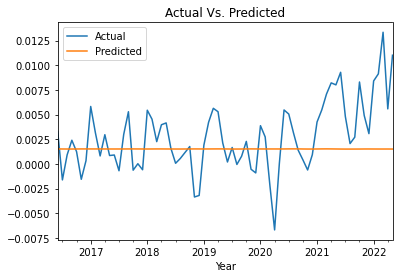

In [21]:
CPI.plot(title="Actual Vs. Predicted")

In [22]:
# Print the Classification Report
from sklearn.metrics import classification_report
print(classification_report(results.Actual, results.Predicted))

NameError: name 'results' is not defined